In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

In [3]:
PATH = Path("/home/ubuntu/data/sandwich/")

In [4]:
# list(PATH.iterdir())

In [5]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Data augmentation

In [6]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]


# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

# Train-validation split

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
def get_files(path):
    paths = [d for d in list(path.iterdir()) if d.is_dir()]
    files = [f for d in paths for f in list(d.iterdir())]
    return files

In [9]:
path=PATH/"train-315"

In [10]:
files = get_files(path)

In [11]:
# files

In [12]:
file_labels = [p.parts[-2] for p in files]

In [13]:
train_files, valid_files, y_train, y_valid = train_test_split(files, file_labels, test_size=0.2, random_state=42)

In [14]:
# from collections import Counter

In [15]:
# Counter(y_train), Counter(y_valid)

# Dataset

In [16]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [17]:
paths = [d for d in list(path.iterdir()) if d.is_dir()]

In [18]:
labels = [p.parts[-1] for p in paths]

In [19]:
labels

['hot_dog',
 'pulled_pork_sandwich',
 'grilled_cheese_sandwich',
 'lobster_roll_sandwich',
 'hamburger',
 'club_sandwich']

In [20]:
class SandwichDataset(Dataset):
    def __init__(self, files, labels, transforms=False):
        self.files = files
        self.label2ind = {v:k for k,v in enumerate(labels)}
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        name = path.parts[-1]
        y_class = self.label2ind[path.parts[-2]]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transforms:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x = random_crop(x)
        else:
            x = center_crop(x)
        x = normalize(x)
        y = self.label2ind[path.parts[-2]]
        return np.rollaxis(x, 2), y

In [21]:
train_ds = SandwichDataset(files=train_files, labels=labels, transforms=True)

In [22]:
valid_ds = SandwichDataset(files=valid_files, labels=labels, transforms=False)

In [23]:
# len(train_ds), len(valid_ds)

In [24]:
x, y = train_ds[0]

In [25]:
# x.shape, y

In [26]:
batch_size = 50

In [27]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [28]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [29]:
x, y = next(iter(train_dl))

In [30]:
x = x.cuda().float()
y = y.cuda()

In [31]:
# x.shape, y.shape

In [32]:
# y.shape[0]

# Initialize pre-trained model with frozen hidden layers

In [33]:
import pretrainedmodels

In [34]:
# model_name = 'inceptionresnetv2'

In [35]:
# model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')

In [36]:
downloaded_model_path = Path("/home/ubuntu/models/sandwich/downloaded_inceptionresnetv2.pth")

In [37]:
# torch.save(model, downloaded_model_path)

In [38]:
inception_resnet = torch.load(downloaded_model_path)

In [39]:
layers = list(inception_resnet.children())

In [40]:
print(len(layers))

17


In [100]:
# layers[10]

In [42]:
inception_resnet.last_linear

Linear(in_features=1536, out_features=1000, bias=True)

In [43]:
class InceptionResnet(nn.Module):
    def __init__(self):
        super(InceptionResnet, self).__init__()
        model = torch.load(Path("/home/ubuntu/models/sandwich/downloaded_inceptionresnetv2.pth"))
        # freezing parameters
        for param in model.parameters():
            param.requires_grad = False
        layers = list(model.children())[:16]
        self.top_model = nn.Sequential(*layers).cuda()
        self.fc = nn.Linear(1536, 6)
    
    def forward(self, x):
        x = self.top_model(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [44]:
model = InceptionResnet().cuda()

In [45]:
out = model(x)

In [46]:
# out.shape

In [47]:
# _, pred = torch.max(out, 1)

In [48]:
# pred

In [49]:
# y

In [50]:
# pred.eq(y).sum()

In [51]:
F.cross_entropy(out, y).item()

1.8069114685058594

# Compute accuracy

In [52]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    return sum_loss/total, correct/total

In [53]:
val_metrics(model, valid_dl)

(1.8276948597696092, 0.20222222222222222)

# Train model with fixed learning rate

In [54]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [55]:
model_path = Path("/home/ubuntu/models/sandwich/")

In [56]:
def get_optimizer(model, lr=0.01, wd=0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [57]:
def train(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            _, pred = torch.max(out, 1)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.7:
                path = "{0}/ft_inceptionresnet_loss_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [58]:
model = InceptionResnet().cuda()

In [59]:
train(model, epochs=10, learning_rate=0.01)

train loss 1.468 val loss 0.965 val accuracy 0.666
train loss 0.959 val loss 1.081 val accuracy 0.597
train loss 0.862 val loss 1.097 val accuracy 0.642
train loss 0.837 val loss 0.959 val accuracy 0.701
/home/ubuntu/models/sandwich/ft_inceptionresnet_loss_70.pth
/home/ubuntu/models/sandwich/ft_inceptionresnet_loss_72.pth
train loss 0.819 val loss 1.042 val accuracy 0.646


In [60]:
save_model(model, model_path/"initial_inceptionresnet.pth")

# Unfreeze top 4 hidden layers, train with lower learning rate¶

In [58]:
model = InceptionResnet().cuda()

In [59]:
load_model(model, model_path/"ft_inceptionresnet_loss_72.pth")

In [60]:
val_metrics(model, valid_dl)

(0.8680179251564873, 0.7222222222222222)

In [61]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [62]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [63]:
unfreeze(model, 15)
unfreeze(model, 14)
unfreeze(model, 13)
unfreeze(model, 12)

In [64]:
train(model, epochs=20, learning_rate=0.001)

train loss 0.931 val loss 1.279 val accuracy 0.722
/home/ubuntu/models/sandwich/ft_inceptionresnet_loss_72.pth
/home/ubuntu/models/sandwich/ft_inceptionresnet_loss_79.pth
train loss 0.286 val loss 0.710 val accuracy 0.797
/home/ubuntu/models/sandwich/ft_inceptionresnet_loss_80.pth
train loss 0.164 val loss 0.837 val accuracy 0.820
/home/ubuntu/models/sandwich/ft_inceptionresnet_loss_82.pth
train loss 0.102 val loss 0.824 val accuracy 0.803
train loss 0.098 val loss 0.943 val accuracy 0.803
train loss 0.068 val loss 1.173 val accuracy 0.794
train loss 0.064 val loss 1.311 val accuracy 0.789
train loss 0.096 val loss 0.882 val accuracy 0.804
train loss 0.059 val loss 0.951 val accuracy 0.821
/home/ubuntu/models/sandwich/ft_inceptionresnet_loss_82.pth
/home/ubuntu/models/sandwich/ft_inceptionresnet_loss_84.pth
train loss 0.034 val loss 0.913 val accuracy 0.823


# Learning rate range test

In [65]:
def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.1, epochs=5):
    losses = []
    p = model_path/"inceptionresnet_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    optimizer = get_optimizer(model, lr=lrs[0], wd=0.0)
    for i in range(epochs):
        for x, y in train_dl:
            update_optimizer(optimizer, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind += 1
            
    load_model(model, str(p))
    return lrs, losses

In [66]:
model = InceptionResnet().cuda()

In [67]:
lrs, losses = LR_range_finder(model, train_dl)

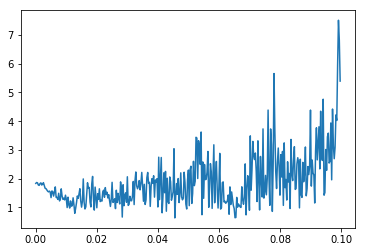

In [68]:
plt.plot(lrs, losses)
plt.show()

# Discriminative fine-tuning, gradual unfreezing, and 1-cycle triangular learning rate

In [91]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [93]:
def create_optimizer(model, lr0):
    param_groups = [list(model.groups[i].parameters()) for i in range(3)] # Different parameters groups for optimizer
    params = [{'params':p, 'lr': lr} for p,lr in zip(param_groups, [lr0/9, lr0/3, lr0])] # Different learning rates for groups
    return optim.Adam(params)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [84]:
class InceptionResnetV2(nn.Module):
    def __init__(self):
        super(InceptionResnetV2, self).__init__()
        model = torch.load(Path("/home/ubuntu/models/sandwich/downloaded_inceptionresnetv2.pth"))
        # freezing parameters
        for param in model.parameters():
            param.requires_grad = False
        layers = list(model.children())[:16]
        self.groups = nn.ModuleList([nn.Sequential(*h) for h in [layers[:12], layers[12:]]])
        self.groups.append(nn.Linear(1536, 6))
    
    def forward(self, x):
        for group in self.groups[:2]:
            x = group(x)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[2](x) # Linear layer
        return x
    
    def freeze(self):
        for param in self.resnet.parameters():
            param.requires_grad = False
            
    def unfreeze(self, group_idx:int): # Unfreeze a group
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x,'requires_grad'), group.parameters())
        for p in parameters: 
            p.requires_grad = True

In [70]:
def train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.03, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr]) # In each iteration, update group learning rates
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            if idx == int(0.1*iterations):
                model.unfreeze(1)
                print(idx, "unfreezing 1")
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.8:
                path = "{0}/ft_inceptionresnet_loss_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

In [85]:
model = InceptionResnetV2().cuda()

In [86]:
val_metrics(model, valid_dl)

(1.8487173252635531, 0.13333333333333333)

In [87]:
batch_size = 50

In [88]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [89]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [94]:
train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.03, epochs=30)

train_loss 1.448 val_loss 1.172 val_acc 0.584
train_loss 1.114 val_loss 1.110 val_acc 0.591
216 unfreezing 1
train_loss 1.005 val_loss 0.934 val_acc 0.678
train_loss 1.134 val_loss 0.816 val_acc 0.749
train_loss 0.681 val_loss 1.015 val_acc 0.733
train_loss 0.620 val_loss 1.359 val_acc 0.669
train_loss 0.566 val_loss 0.863 val_acc 0.757
train_loss 0.501 val_loss 5.367 val_acc 0.616
train_loss 0.403 val_loss 0.750 val_acc 0.801
/home/ubuntu/models/sandwich/ft_inceptionresnet_loss_80.pth
train_loss 0.332 val_loss 0.692 val_acc 0.789
train_loss 0.274 val_loss 0.769 val_acc 0.790
train_loss 0.242 val_loss 0.661 val_acc 0.802
/home/ubuntu/models/sandwich/ft_inceptionresnet_loss_80.pth
train_loss 0.251 val_loss 0.706 val_acc 0.804
/home/ubuntu/models/sandwich/ft_inceptionresnet_loss_80.pth
train_loss 0.176 val_loss 0.706 val_acc 0.818
/home/ubuntu/models/sandwich/ft_inceptionresnet_loss_82.pth
train_loss 0.171 val_loss 0.732 val_acc 0.807
train_loss 0.103 val_loss 0.773 val_acc 0.814
train_l

0.01521905025037995